# Train-Validation

In [60]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from paretoset import paretoset
import numpy as np
from copy import deepcopy

In [61]:
percentages = [2.5, 5, 25, 50, 75, 100, 200]
datasets_names = {
    'kuhar': 'KH',
    'motionsense': 'MS',
    'realworld_thigh': 'RW-T',
    'realworld_waist': 'RW-W',
    'uci': 'UCI',
    'wisdm': 'WISDM',
}
reducer_names = {
    'ae': 'AE',
    'tae': 'TAE',
    'convae': 'ConvAE',
    'convtae': 'ConvTAE',
    'pca': 'PCA',
    'umap': 'UMAP'
}

In [62]:
TV_nor_df = pd.read_csv('TV_no_reducer_scores.csv')
nor_reordered = TV_nor_df.groupby(['dataset', 'model']).max().pivot_table(index='dataset', columns='model', values='score').T
nor_reordered = nor_reordered.reset_index(drop=True)
nor_reordered

dataset,kuhar,motionsense,realworld_thigh,realworld_waist,uci,wisdm
0,0.671127,0.785952,0.671521,0.787217,0.847059,0.747373


In [63]:
nor_reordered.loc[0, 'kuhar']

0.6711267605633803

In [64]:
data = pd.read_csv('../experiments/P10_ae_kuhar_p5_mc3/data.csv')

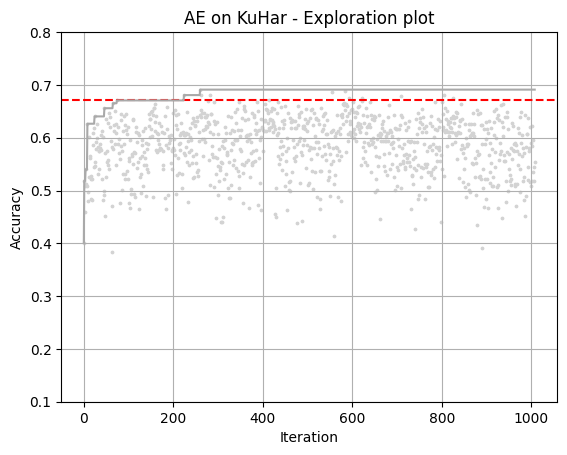

In [69]:
# General plot
plt.axhline(y=nor_reordered.reset_index(drop=True).loc[0,'kuhar'], color='red', linestyle='--')
plt.scatter(data['Unnamed: 0'], data['score'], marker='o', color='lightgray', s=3)
plt.plot(data['Unnamed: 0'], data['score'].cummax(), color='darkgray')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('AE on KuHar - Exploration plot')
plt.ylim(bottom=0.1, top=0.8)
plt.grid()
plt.show()

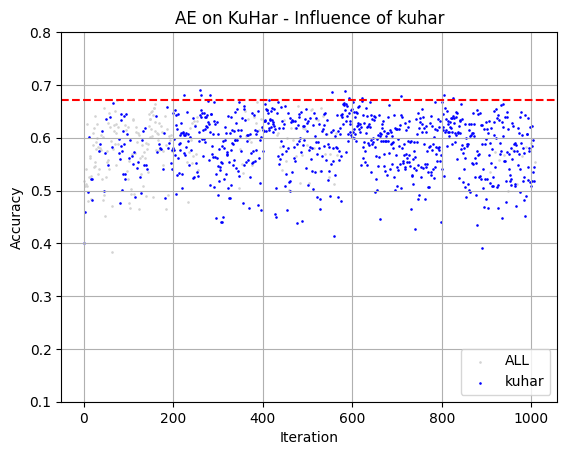

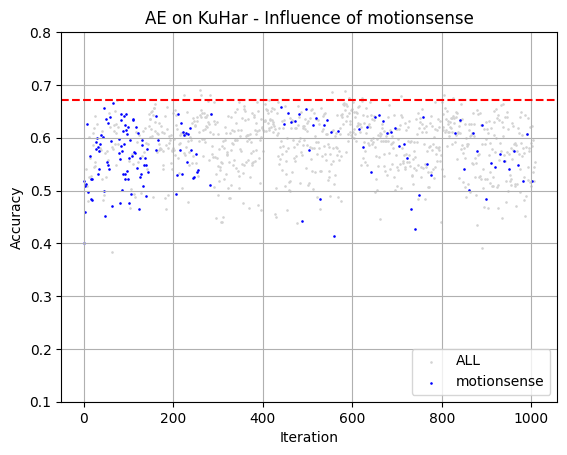

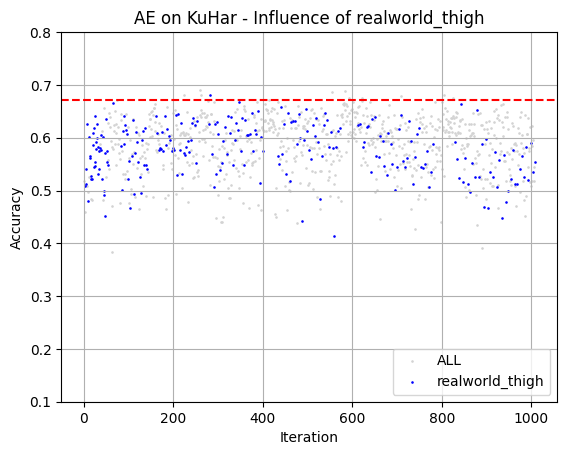

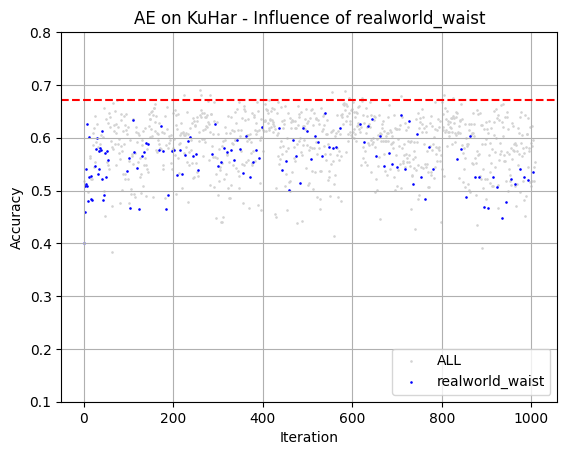

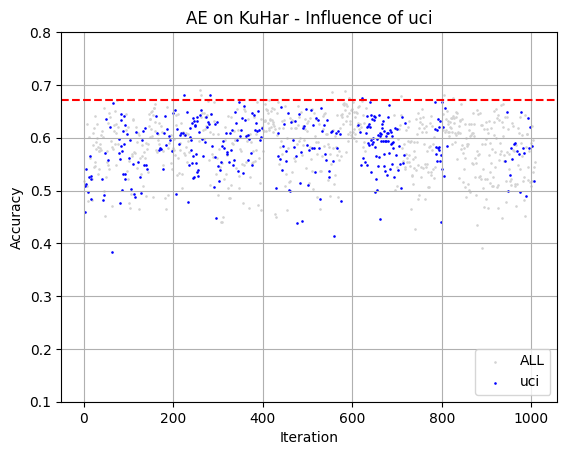

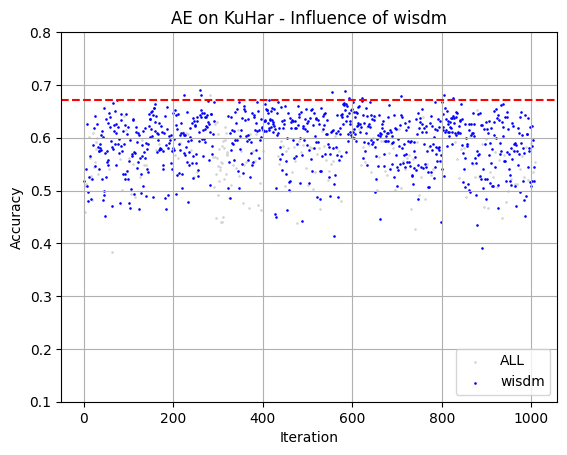

In [70]:
# Influence of dataset in the exploration
for dataset in datasets_names:
    plt.axhline(y=nor_reordered.loc[0,'kuhar'], color='red', linestyle='--')
    mask = data[f'config/MC-red_dataset-{dataset}.standartized_balanced[train]'] == 1
    # scatter_all = 
    plt.scatter(data[~mask]['Unnamed: 0'], data[~mask]['score'], marker='.', color='lightgray', s=3, label='ALL')
    # scatter_mask = 
    plt.scatter(data[mask]['Unnamed: 0'], data[mask]['score'], marker='.', color='blue', s=3, label=dataset)
    # plt.plot(data['Unnamed: 0'], data['score'].cummax(), color='darkgray')
    # plt.legend([scatter_all, scatter_mask], ['ALL', dataset], loc='lower right')
    plt.legend(loc='lower right')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title(f'AE on KuHar - Influence of {dataset}')
    plt.ylim(bottom=0.1, top=0.8)
    plt.grid()
    plt.show()

In [67]:
pareto_mask = paretoset(data[['config/latent_dim', 'score']], sense=['min', 'max'])
pareto_df = data[pareto_mask]
pareto_df = pareto_df.sort_values(by='config/latent_dim')

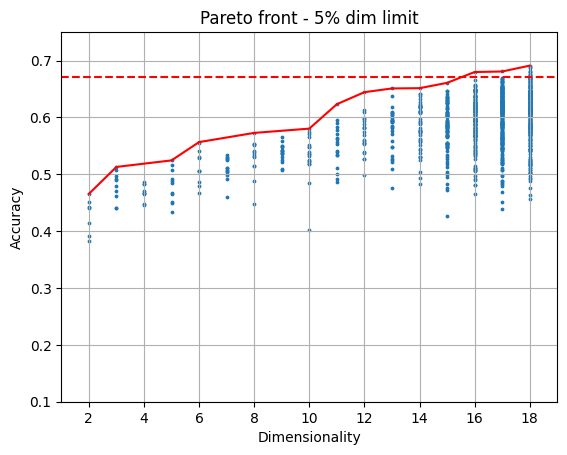

In [68]:
plt.axhline(y=nor_reordered.reset_index(drop=True).loc[0,'kuhar'], color='red', linestyle='--')
plt.plot(pareto_df['config/latent_dim'], pareto_df['score'], label='model', color='red')
plt.title('Pareto front - 5% dim limit')
plt.scatter(data['config/latent_dim'], data['score'], label='model', s=3)
# plt.scatter(reducer_df['config/latent_dim'], reducer_df['score'], s=5, marker='x')
plt.xlabel('Dimensionality')
plt.ylabel('Accuracy')
plt.xlim(1, 19)
plt.ylim(0.1, 0.75)
plt.grid()
# plt.savefig('pareto_50.png')
plt.show()

# Test ConvAE models

In [156]:
import torch
from torch import nn
encoder_layers = []
in_channels = 6
kernel_size = 3
conv_stride = 1
conv_padding = 1
groups = 1
current_input_size = (6,60)
for i in [32, 64, 128, 256]:
# for i in [256]:
    if current_input_size[1] < 3:
        print('continue')
        continue
    conv_layer_to_append = nn.Conv1d(
        in_channels=in_channels,
        out_channels=i,
        kernel_size=kernel_size,
        stride=conv_stride,
        padding=conv_padding,
        groups=groups
        )
    test_data = torch.randn(current_input_size)
    print('START WITH', test_data.size(), 'THEN')
    test_data = conv_layer_to_append(test_data)
    print(test_data.size(), 'THEN')
    current_input_size = test_data.size()
    in_channels = test_data.size(0)
    if current_input_size[1] < 3:
        print('continue2')
        continue
    pool_layer_to_append = nn.MaxPool1d(kernel_size=3, stride=3)
    test_data = pool_layer_to_append(test_data)
    print(test_data.size(), 'END')
    current_input_size = test_data.size()
    in_channels = test_data.size(0)
    relu_layer_to_append = nn.ReLU()
    encoder_layers.append(conv_layer_to_append)
    encoder_layers.append(pool_layer_to_append)
    encoder_layers.append(relu_layer_to_append)
    
    

START WITH torch.Size([6, 60]) THEN
torch.Size([32, 60]) THEN
torch.Size([32, 20]) END
START WITH torch.Size([32, 20]) THEN
torch.Size([64, 20]) THEN
torch.Size([64, 6]) END
START WITH torch.Size([64, 6]) THEN
torch.Size([128, 6]) THEN
torch.Size([128, 2]) END
continue


In [166]:
np.linspace(13, 19, 2) # Case of 0 fc
np.linspace(13, 19, 3) # Case of 1 fc

array([13., 16., 19.])

In [157]:
encoder = nn.Sequential(*encoder_layers)
# Get the number of trainable parameters
sum(p.numel() for p in encoder.parameters() if p.requires_grad)

31520

In [159]:
for p in encoder[0].parameters():
    print(p.numel(), p.requires_grad, p.size())

576 True torch.Size([32, 6, 3])
32 True torch.Size([32])


In [160]:
16*6*3

288

In [9]:
estimator_result = {
    'acc': 0.5,
    'f1': 0.6,
    'precision': 0.7
}
estimator_name = 'test'
for key in estimator_result.keys():
    estimator_result[f"{estimator_name}-{key}"] = estimator_result.pop(key)
        
estimator_result

{'test-acc': 0.5, 'test-f1': 0.6, 'test-precision': 0.7}

In [15]:
for i in [{'a': 's'}, {'b': 'd'}]:
    print(i)
obj = {'asd1': 'asd2', 'asd3': 'asd4'}
for i in obj:
    print(i, obj[i])

{'a': 's'}
{'b': 'd'}
asd1 asd2
asd3 asd4


In [16]:
[] == []

True